## Organize imports, labeling, visualization

In [14]:
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np

# for downprojection through KDA:
# ! pip install pyDML
import dml

import glob
import os

import librosa
import math
from collections import defaultdict

In [15]:
def simple_visualizer(zyx_signal, position_second_one):
    plt.title('whole signal')
    plt.plot(zyx_signal)
    plt.show()
    
    plt.title('first three seconds of signal')
    plt.plot(zyx_signal[:position_second_one*3+1,:])
    plt.show()
    
    plt.title('first six seconds of signal')
    plt.plot(zyx_signal[:position_second_one*3*2+1,:])
    plt.show()
    
    return

## Pre-process signal

### Cutting and synchronizing the device signals

In [16]:
def id_shorter(number):
    ''' return the first elven digits of a number/ID '''

    string_n = str(number)
    
    if 'e' in string_n:
        
        e_ind = string_n.index('e')
        length_n = 1 + int(string_n[e_ind+1:])
        
    else:
        
        length_n = len(string_n)

    diff = length_n - 11 # number of 0-s show number of removed values

    if diff <= 0:
        
        return int(number)

    return int(number // 10**diff) 

In [17]:
label_dict = {'A':'1', 'B':'2'}

def file_comparison(path='dataset/*/*/Accelerometer.csv'):
    
    first_time_stamps_each_file = {}
    last_time_stamps_each_file = {}
    
    for file in glob.glob(path):
        
        zyx_pd = pd.read_csv(file, header=0)
        
        label_name = file.split('/')[-3]
        label = label_dict[label_name]
        
        position_second_one = np.where(zyx_pd['seconds_elapsed'].to_numpy()>=1)[0][0]

        # Cut away the first and last ten seconds of a signal:
        zyx_pd_cut = zyx_pd[position_second_one*10:(len(zyx_pd['z'].values)-position_second_one*10)]
        zyx_signal = zyx_pd_cut.to_numpy()[:,-3:]
        time_history_cut = zyx_pd_cut.to_numpy()[:,0]
        
        # first 11 digits of timestamp should be identical in both devices:
        first_time_stamp = time_history_cut[0]
        first_time_stamp = id_shorter(first_time_stamp)
        
        last_time_stamp = time_history_cut[-1]
        last_time_stamp = id_shorter(last_time_stamp)

        
        key = file.split('/')[-2] # file name
        
        if key in first_time_stamps_each_file.keys():
            
            if first_time_stamps_each_file[key] < first_time_stamp:
                first_time_stamps_each_file[key] = first_time_stamp

            if last_time_stamps_each_file[key] > last_time_stamp:
                last_time_stamps_each_file[key] = last_time_stamp
                
        else:
            
            first_time_stamps_each_file[key] = first_time_stamp
            last_time_stamps_each_file[key] = last_time_stamp

    return first_time_stamps_each_file, last_time_stamps_each_file
        

In [18]:
def preprocess(file, start_where, end_where):
    
    # cut:
    zyx_pd = pd.read_csv(file, header=0)
    zyx_signal = zyx_pd.to_numpy()
    
    
    time_ids = []
    for value in zyx_signal[:,0]:
        time_ids.append(id_shorter(value))

    time_ids = np.asarray(time_ids, 'int')

    row_start = np.where(time_ids == start_where)[0][0]
    row_end = np.where(time_ids == end_where)[0][0]
    
    zyx_signal = zyx_signal[row_start:row_end+1,:]
    zyx_signal = zyx_signal[:,-3:]

    # nomalize_values:
    zyx_signal[:,0] = (zyx_signal[:,0] - zyx_signal[:,0].mean())/zyx_signal[:,0].std()
    zyx_signal[:,1] = (zyx_signal[:,1] - zyx_signal[:,1].mean())/zyx_signal[:,1].std()
    zyx_signal[:,2] = (zyx_signal[:,2] - zyx_signal[:,2].mean())/zyx_signal[:,2].std()

    print('file:', file)
    simple_visualizer(zyx_signal, position_second_one)

    # filtering:
    filtered_signal_z, filtered_signal_y, filtered_signal_x = butter_filtering(zyx_signal)
    
    return filtered_signal_z, filtered_signal_y, filtered_signal_x

### Filter signal: butterworth

In [19]:
def butter_filtering(zyx_signal):
    
    butterworth = scipy.signal.butter(N=5, Wn=9, btype='low', analog=False, output='sos', fs=20)

    # for z-axis:
    filtered_signal_z = scipy.signal.sosfilt(butterworth, zyx_signal[:,0])
    # for y-axis:
    filtered_signal_y = scipy.signal.sosfilt(butterworth, zyx_signal[:,1])
    # for x-axis:
    filtered_signal_x = scipy.signal.sosfilt(butterworth, zyx_signal[:,2])

    
    plt.title('before and after filtering z')
    plt.plot(zyx_signal[:,0],label='original signal')
    plt.plot(filtered_signal_z,label='filtered signal')
    plt.legend()
    plt.show()

    plt.title('before and after filtering y')
    plt.plot(zyx_signal[:,1],label='original signal')
    plt.plot(filtered_signal_y,label='filtered signal')
    plt.legend()
    plt.show()

    plt.title('before and after filtering x')
    plt.plot(zyx_signal[:,2],label='original signal')
    plt.plot(filtered_signal_x,label='filtered signal')
    plt.legend()
    plt.show()  
    
    print('###########################################################\n\n')

        
    return filtered_signal_z, filtered_signal_y, filtered_signal_x

## Store signal dimensions of both devices in an arff file

In [20]:
def arff_saver(Z1, Y1, X1, Z2, Y2, X2):
    ''' append arff by one file, creating one arff file in which all data is provided '''
        
    os.makedirs('feat_arff', exist_ok=True)
    
    #arff_name = f'feat_arff/all_feat_label{kwargs[-1]}.arff' 
    arff_name = f'feat_arff/all_devices_all_axes.arff' 

    if not os.path.exists(arff_name):
       
        with open(arff_name, 'w') as f:
            
            f.write(('@relation firstset\n'))
            
            f.write((f'@attribute Z1 real\n'))
            f.write((f'@attribute Y1 real\n'))
            f.write((f'@attribute X1 real\n'))
            
            f.write((f'@attribute Z2 real\n'))
            f.write((f'@attribute Y2 real\n'))
            f.write((f'@attribute X2 real\n'))

            f.write('@data\n')
         
        
    with open(arff_name, 'a') as f:

        for z1, y1, x1, z2, y2, x2 in zip(Z1, Y1, X1, Z2, Y2, X2):
            f.write(f'{z1}, {y1}, {x1}, {z2}, {y2}, {x2}\n')
     
    return

## Bringing all together

current label: 1


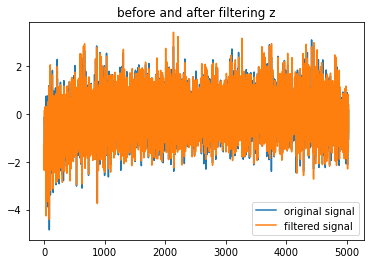

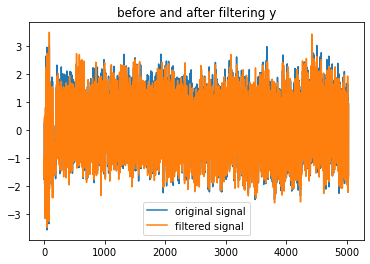

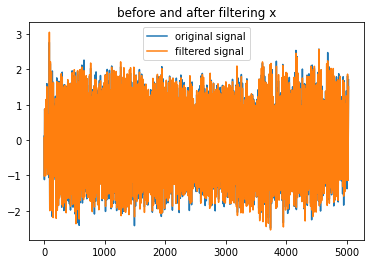

###########################################################




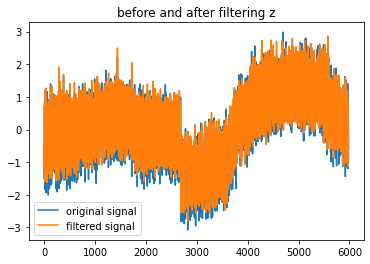

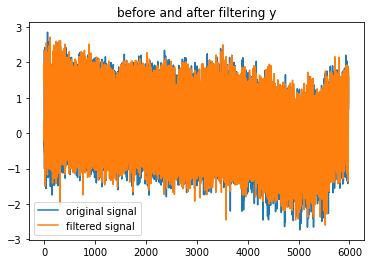

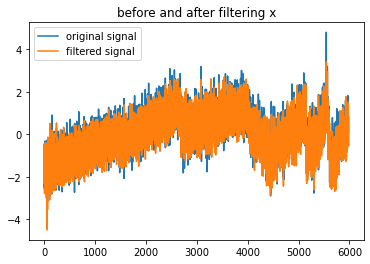

###########################################################


current label: 1


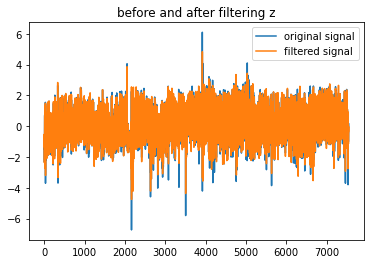

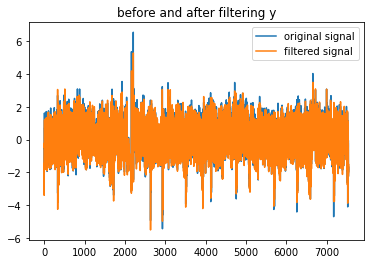

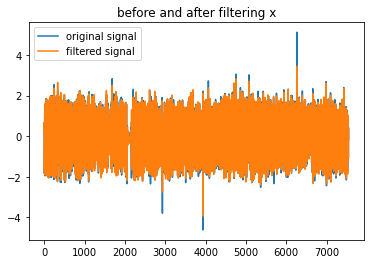

###########################################################




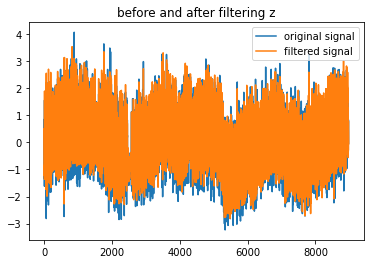

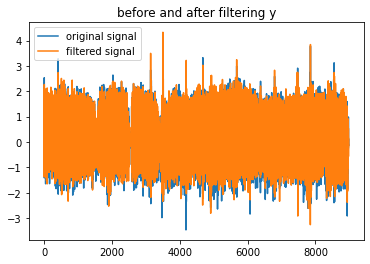

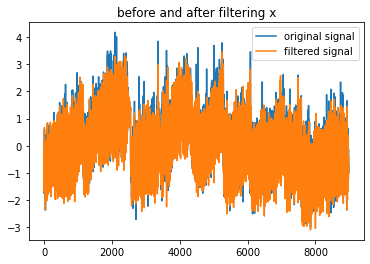

###########################################################


current label: 1


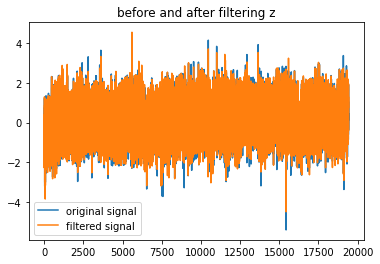

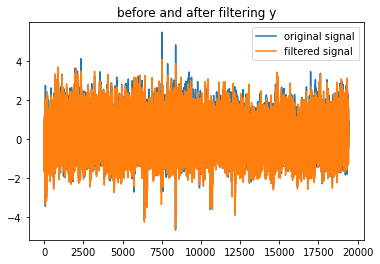

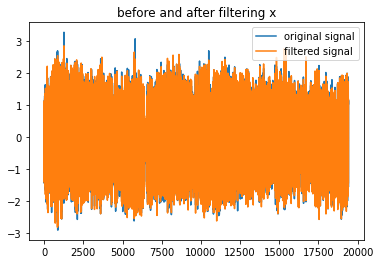

###########################################################




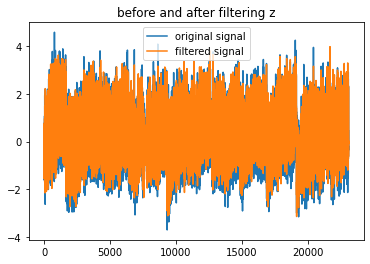

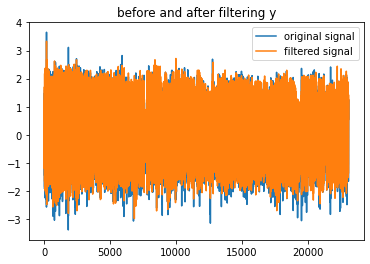

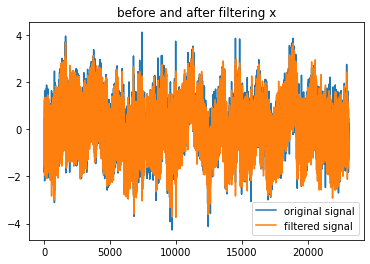

###########################################################


current label: 1


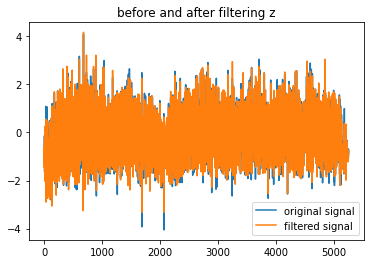

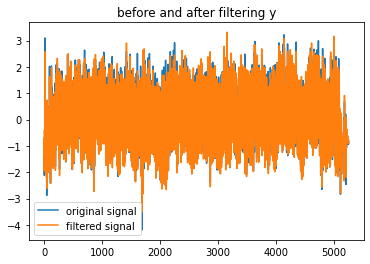

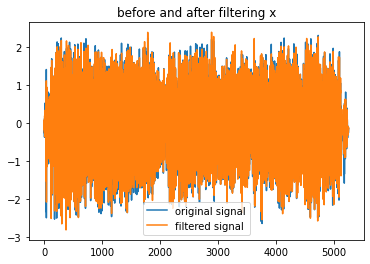

###########################################################




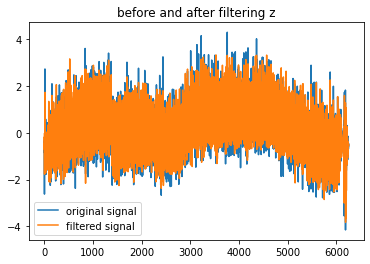

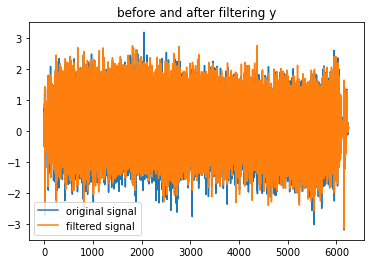

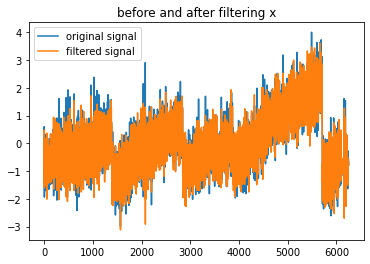

###########################################################


current label: 1


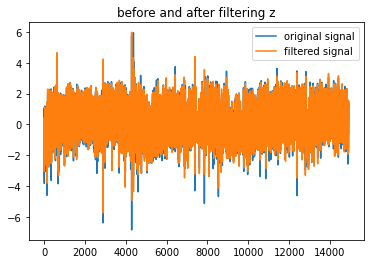

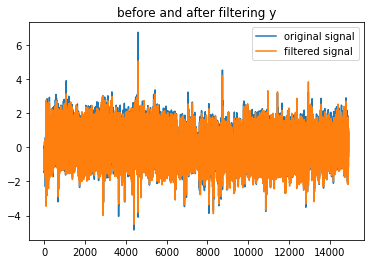

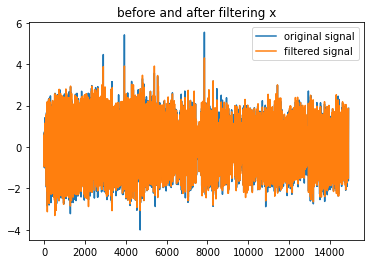

###########################################################




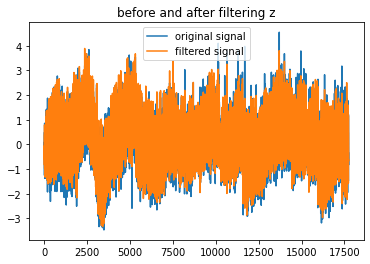

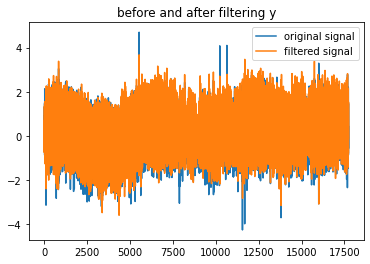

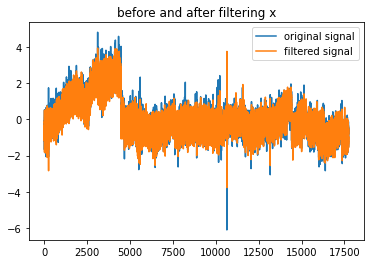

###########################################################


current label: 1


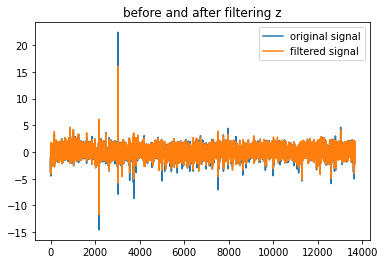

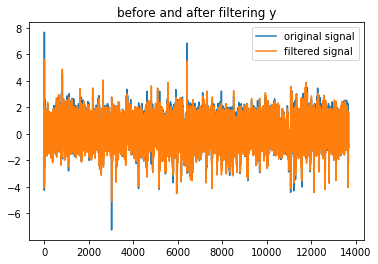

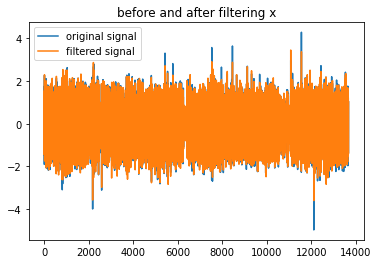

###########################################################




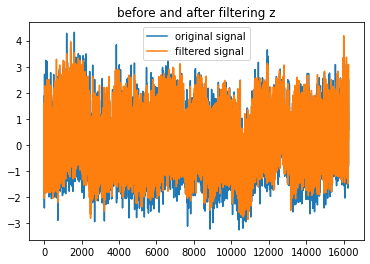

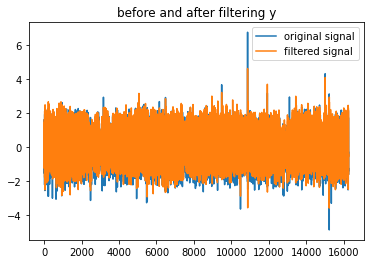

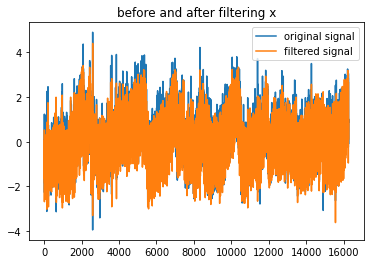

###########################################################




In [21]:
path = 'dataset/*/*/Accelerometer.csv'
first_time_stamps_each_file, last_time_stamps_each_file = file_comparison(path)

for file in glob.glob('dataset/A/*/Accelerometer.csv'):
    
    label_name = file.split('/')[-3]
    label = label_dict[label_name]
    print('current label:',label)
    file_name = file.split('/')[-2]
    start_where = first_time_stamps_each_file[file_name]
    end_where = last_time_stamps_each_file[file_name]
    
    filtered_signal_z1, filtered_signal_y1, filtered_signal_x1 = preprocess(file, start_where, end_where)

    # do same for the file of the same time frame but other class:
    B_label_path = file.split('/')[0] + '/B/' + '/'.join(file.split('/')[-2:])
    filtered_signal_z2, filtered_signal_y2, filtered_signal_x2 = preprocess(B_label_path, start_where, end_where)
  
    #arff_saver(filtered_signal_z1, filtered_signal_y1, filtered_signal_x1, filtered_signal_z2, filtered_signal_y2, filtered_signal_x2)

        

## Train-test-split

In [1]:
def arff_saver2(tuple_array, mode):

    arff_name = f'feat_arff/{mode}_time_series_all_devices_all_axes_tenth_size.arff'

    with open(arff_name, 'w') as f:

        f.write((f'@relation {mode}set\n'))

        f.write((f'@attribute Z1 real\n'))
        f.write((f'@attribute Y1 real\n'))
        f.write((f'@attribute X1 real\n'))

        f.write((f'@attribute Z2 real\n'))
        f.write((f'@attribute Y2 real\n'))
        f.write((f'@attribute X2 real\n'))

        f.write('@data\n')
         
        for row in tuple_array:
            f.write(str(row)[1:-1])
            f.write('\n')
            
    return 

In [2]:
# load arff file:
from scipy.io import arff
from io import StringIO

arff_path = 'feat_arff/all_devices_all_axes.arff'
data, meta = arff.loadarff(arff_path)

# shuffle samples:
# (do this not for Gaussian process as it relys on autocorrelation/signal in time order)
#np.random.seed(0)
#np.random.shuffle(data)
data = data[:len(data)//10]

# 80-20 split:
number_train = len(data) * 80 // 100
train_data = data[:number_train]
test_data = data[number_train:]


# store the datasets in two arff files:
arff_saver2(train_data, 'train')
arff_saver2(test_data, 'test')
